In [1]:

import time
import unittest
import numpy as np
import rospy
import bisect
from imitation_learning_ros_package.srv import SendRelCor
import src.sim.ros.python3_ros_ws.src.imitation_learning_ros_package.rosnodes.waypoint_extractor as wpx
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from IPython.display import clear_output


In [73]:
#Using the 2d_location (SLOW) and the depth using triangulation
am_pics = 1271
waypoint_extr = wpx.WaypointExtractor()

dual_pictures = np.linspace(1,am_pics,am_pics)
triang_coor_slow = []
im_coor_1 = [0, 0, 0]
im_coor_2 = [0, 0, 0]

start_time = time.time()
for img_idx in range(len(dual_pictures)):
    path_1 = '/home/thomas/code/imitation-learning-codebase/src/sim/ros/python3_ros_ws/src/imitation_learning_ros_package/rosnodes/all_pics/' + str(int(dual_pictures[img_idx])) + '_1.jpg'
    path_2 = '/home/thomas/code/imitation-learning-codebase/src/sim/ros/python3_ros_ws/src/imitation_learning_ros_package/rosnodes/all_pics/' + str(int(dual_pictures[img_idx])) + '_2.jpg'
    current_image_1 = cv2.imread(path_1, cv2.IMREAD_GRAYSCALE)
    current_image_2 = cv2.imread(path_2, cv2.IMREAD_GRAYSCALE)
    bin_im_1 = waypoint_extr.get_cone_binary(current_image_1, threshold=90)
    bin_im_2 = waypoint_extr.get_cone_binary(current_image_2, threshold=90)
    im_coor_1 = waypoint_extr.get_cone_2d_location(bin_im_1)# im_coor_1)
    im_coor_2 = waypoint_extr.get_cone_2d_location(bin_im_2)# im_coor_2)
    current_3d_coor = waypoint_extr.get_depth_triang(im_coor_1[0], im_coor_2[0], im_coor_1[1], im_coor_2[1])
    rotation_coordinates = np.array([current_3d_coor[0],current_3d_coor[1],current_3d_coor[2]])
    triang_coor_slow.append(rotation_coordinates)
    

In [31]:
#Using the 2d_location SPEEDUP and the depth using triangulation
am_pics = 1271
waypoint_extr = wpx.WaypointExtractor()

dual_pictures = np.linspace(1,am_pics,am_pics)
triang_coor_speedup = []
im_coor_1 = [0, 0, 0]
im_coor_2 = [0, 0, 0]

start_time = time.time()
for img_idx in range(len(dual_pictures)):
    clear_output(wait=True)
    print('progress: %f /100' % (img_idx/len(dual_pictures)*100))
    path_1 = '/home/thomas/code/imitation-learning-codebase/src/sim/ros/python3_ros_ws/src/imitation_learning_ros_package/rosnodes/all_pics/' + str(int(dual_pictures[img_idx])) + '_1.jpg'
    path_2 = '/home/thomas/code/imitation-learning-codebase/src/sim/ros/python3_ros_ws/src/imitation_learning_ros_package/rosnodes/all_pics/' + str(int(dual_pictures[img_idx])) + '_2.jpg'
    current_image_1 = cv2.imread(path_1, cv2.IMREAD_GRAYSCALE)
    current_image_2 = cv2.imread(path_2, cv2.IMREAD_GRAYSCALE)
    bin_im_1 = waypoint_extr.get_cone_binary(current_image_1, threshold=90)
    bin_im_2 = waypoint_extr.get_cone_binary(current_image_2, threshold=90)
    im_coor_1 = waypoint_extr.get_cone_2d_speedup(bin_im_1, im_coor_1)
    im_coor_2 = waypoint_extr.get_cone_2d_speedup(bin_im_2, im_coor_2)
    current_3d_coor = waypoint_extr.get_depth_triang(im_coor_1[0], im_coor_2[0], im_coor_1[1], im_coor_2[1])
    rotation_coordinates = np.array([current_3d_coor[0],current_3d_coor[1],current_3d_coor[2]])
    triang_coor_speedup.append(rotation_coordinates)
print('progress: 100/100')

progress: 99.921322 /100


In [74]:
    def transform_coordinates(point: np.ndarray,
                  orientation: np.ndarray = np.eye(3),
                  translation: np.ndarray = np.zeros((3,)),
                  invert: bool = False) -> np.ndarray:
        transformation = np.zeros((4, 4))
        transformation[0:3, 0:3] = orientation
        transformation[0:3, 3] = translation
        transformation[3, 3] = 1
        point = np.concatenate([point, np.ones(1,)])
        if invert:
            transformation = np.linalg.inv(transformation)
        return np.matmul(transformation, point)

In [75]:
 def get_translations():
            translations = []
            translations_time = []
            with open('/home/thomas/code/imitation-learning-codebase/transform_data/translation_data.txt') as f:
                lines = f.readlines()
                first_line = True
                for line in lines:
                    line = line.strip()
                    if line:
                        if first_line:
                            columns = [item.strip() for item in line.split(',')]
                            first_line = False
                        else:
                            if len(translations) == 0:
                                data = [item.strip() for item in line.split(',')]
                                ref_translation = ([float(data[1]),float(data[2]),float(data[3])])
                                ref_time = int(data[0])
                            data = [item.strip() for item in line.split(',')]
                            translations_time.append(int(data[0])-ref_time)
                            translations.append([float(data[1])-ref_translation[0], float(data[2])-ref_translation[1], float(data[3])-ref_translation[2]])
            return translations, translations_time

In [76]:
    def get_rotations():
        rotations = []
        rotations_time = []
        with open('/home/thomas/code/imitation-learning-codebase/transform_data/rotations.txt') as f:
            lines = f.readlines()
            first_line = True
            for line in lines:
                line = line.strip()
                if line:
                    if first_line:
                        columns = [item.strip() for item in line.split(',')]
                        first_line = False
                    else:
                        if len(rotations) == 0:
                            data = [item.strip() for item in line.split(',')]
                            ref_time = int(data[0])
                        data = [item.strip() for item in line.split(',')]
                        rotations_time.append(int(data[0])-ref_time)
                        rotations.append([float(data[1]), float(data[2]), float(data[3]), float(data[4])])
        return  rotations, rotations_time

In [77]:
translation_matrix, translation_times = get_translations()
rot_m, rotation_times = get_rotations()

In [78]:
def get_pic_times():
        pic_times_ns = []
        seconds = ''
        with open('/home/thomas/code/imitation-learning-codebase/transform_data/timestamps_pics.txt') as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip()
                if line:
                    if seconds == '':
                        data = [item.strip() for item in line.split(' ')]
                        ref_time_s = data[1]
                    if len(pic_times_ns) == 0:
                        data = [item.strip() for item in line.split(' ')]
                        ref_time_ns = int(ref_time_s + data[1])
                    data = [item.strip() for item in line.split(' ')]
                    if len(data) >1:
                        if data[0] == 'secs:':
                            seconds = data[len(data)-1]
                        else:
                            pic_times_ns.append(int(seconds + data[len(data)-1])-ref_time_ns)
                            
        return  pic_times_ns

In [79]:
def get_nearest_stamp_idx(time_stamp,time_list,start_idx,total_len):
    index = start_idx
    while time_stamp > time_list[index]:
        index+=1
    return index

In [81]:
pic_time_ns = get_pic_times()
translation_synchronised = []
rotation_synchronised = []
start_index_translation = 0
start_index_rotation = 0
for pic_time in pic_time_ns:
    start_index_translation = get_nearest_stamp_idx(pic_time,translation_times,start_index_translation,len(pic_time_ns)-1)
    start_index_rotation = get_nearest_stamp_idx(pic_time,rotation_times,start_index_rotation,len(pic_time_ns)-1)
    translation_synchronised.append(translation_matrix[start_index_translation])
    rotation_synchronised.append(rot_m[start_index_rotation])

Text(0, 0.5, 'y ax')

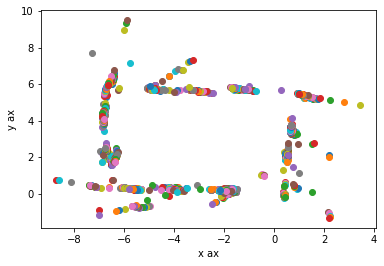

In [91]:
fig = plt.figure()
ax = fig.add_subplot()
global_coor = []
for img_idx in range(0, 1270):
    rot_mat = R.from_quat(rotation_synchronised[img_idx])
    translation = translation_synchronised[img_idx+1]
    rotation_coordinates = triang_coor_slow[img_idx]
    if rotation_coordinates[0] > 0 and rotation_coordinates[0] < 5:
        rotated_coor = transform_coordinates(rotation_coordinates, orientation = rot_mat.as_matrix(), translation = translation)
        global_coor.append(rotated_coor)
    
        ax.scatter(global_coor[len(global_coor)-1][0], global_coor[len(global_coor)-1][1])
#ax.set_xlim(-3,3)
#ax.set_ylim(0,1)
ax.set_xlabel("x ax")
ax.set_ylabel("y ax")



Text(0, 0.5, 'y ax')

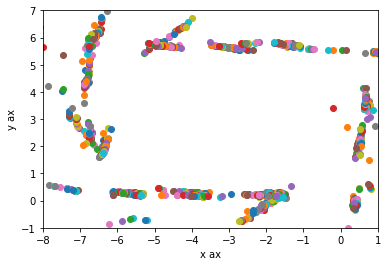

In [116]:
fig = plt.figure()
ax = fig.add_subplot()
global_coor = []
for img_idx in range(0, 1270):
    rot_mat = R.from_quat(rotation_synchronised[img_idx])
    translation = translation_synchronised[img_idx]
    rotation_coordinates = triang_coor_speedup[img_idx]
    if rotation_coordinates[0] >0 and rotation_coordinates[0] < 5:
        rotated_coor = transform_coordinates(rotation_coordinates, orientation = rot_mat.as_matrix(), translation = translation)
        global_coor.append(rotated_coor)
    
        ax.scatter(global_coor[len(global_coor)-1][0], global_coor[len(global_coor)-1][1])
ax.set_xlim(-8,1)
ax.set_ylim(-1,7)
ax.set_xlabel("x ax")
ax.set_ylabel("y ax")


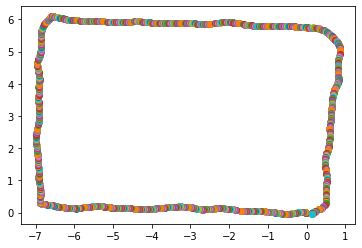

In [71]:
#plot of the translation matrix.
fig = plt.figure()
ax = fig.add_subplot()#111, projection = '3d')
global_coor = []
for img_idx in range(0, 1270):
    rot_mat = R.from_quat(rotation_synchronised[img_idx])
    translation = translation_synchronised[img_idx+1]
    rotation_coordinates = np.array([0,0,0])
    rotated_coor = transform_coordinates(rotation_coordinates, rot_mat.as_matrix(),translation)
    global_coor.append(rotated_coor)
    
    ax.scatter(global_coor[len(global_coor)-1][0], global_coor[len(global_coor)-1][1])#, global_coor[len(global_coor)-1][2])
#ax.set_xlim3d(-8,1)
#ax.set_ylim3d(-1,8)
#ax.set_zlim3d(-1,1)
#ax.set_xlabel("x ax")
#ax.set_ylabel("y ax")
#ax.set_zlabel("z ax")

In [111]:
#take average for 3d coordinates
triang_coor_speedup_averaged = []
triang_coor_speedup_averaged.append(np.array([0,0,0]))
for i in range(1,len(triang_coor_speedup)-1):
    triang_coor_speedup_averaged.append(np.array([(triang_coor_speedup[i-1][0] + triang_coor_speedup[i][0])/2,
                                                (triang_coor_speedup[i-1][1] + triang_coor_speedup[i][1])/2,
                                                (triang_coor_speedup[i-1][2] + triang_coor_speedup[i][2])/2]))

Text(0, 0.5, 'y ax')

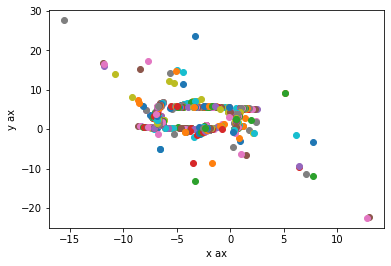

In [114]:
fig = plt.figure()
ax = fig.add_subplot()
global_coor = []
for img_idx in range(0, 1270):
    rot_mat = R.from_quat(rotation_synchronised[img_idx])
    translation = translation_synchronised[img_idx]
    rotation_coordinates = triang_coor_speedup_averaged[img_idx]
    if rotation_coordinates[0] >0 and rotation_coordinates[0] < 50:
        rotated_coor = transform_coordinates(rotation_coordinates, orientation = rot_mat.as_matrix(), translation = translation)
        global_coor.append(rotated_coor)
    
        ax.scatter(global_coor[len(global_coor)-1][0], global_coor[len(global_coor)-1][1])
#ax.set_xlim(-8,1)
#ax.set_ylim(-1,7)
ax.set_xlabel("x ax")
ax.set_ylabel("y ax")

In [109]:
len(triang_coor_speedup_averaged)

1269